# Structural data exploration

Data exploration of ADNI patients. The data consists of features derived from T1 weighted images of patients in their first MRI visit in each phase of the program. The features were extracted using SIENAX to determine tissue types and FIRST to determine subcortical structure volumes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import kruskal, pearsonr
from os.path import exists
from sklearn.linear_model import LinearRegression
from decimal import Decimal

np.random.seed(0)
COMBAT = False

### BrainAge Modelling

Create a model that given features extracted from brain images correctly predicts a patients age in control subjects.

In [2]:
# Load dataframe
df_full = pd.read_csv('../DATA/adni_full_data.csv', index_col=0)
df_full_homo = pd.read_csv('../DATA/adni_full_data_for_homogenisation.csv', index_col=0)

# Mark features to use
# We do not use brain size since its just GM+WM which makes it redundant
features = ['GM', 'WM', 'vscf', 'pgrey', 
        'Thalmus', 'Caudate', 'Putamen', 'Palidum', 
        'Hippo', 'Amygdala', 'Accumbens', 'Brainstem']

# Need to normalize values using vscale for data that is not to be homogenised
for f in features:
    df_full[f] = df_full[f]*df_full['Vscale']
    
# Exctract controls that haven't converted
df_cn = df_full[df_full['TYPECONVERSOR']==1.0]
df_cn_homo = df_full_homo[df_full_homo['TYPECONVERSOR']==1.0]

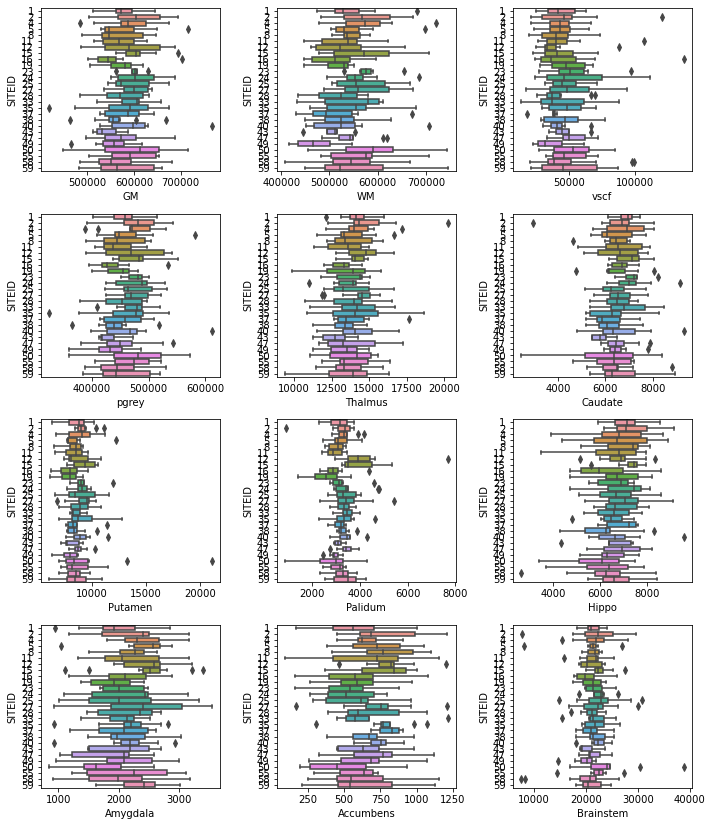

In [3]:
# Explor variability of features by site
plt.figure(figsize=(10,14))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    ax = sns.boxplot(x=feature, y='SITEID', data=df_cn_homo, orient='h')
    plt.tight_layout()

There is great variability in values between each site. So COMBAT can be applied to homogenize data. COMBAT is applied to a version of the data which has sites having more than 10 control subjects in order to be able to homogenize properly.

In [4]:
# Data harmonization with Combat
from pycombat import Combat
combat = Combat()
Y = df_cn_homo[features].to_numpy()
b = df_cn_homo['SITEID'].to_numpy()
X = df_cn_homo['AGE'].to_numpy()[:, np.newaxis]
C = df_cn_homo[['Vscale', 'PTGENDER', 'Phase']].to_numpy()
y_adjusted = combat.fit_transform(Y=Y, b=b, X=X, C=C)

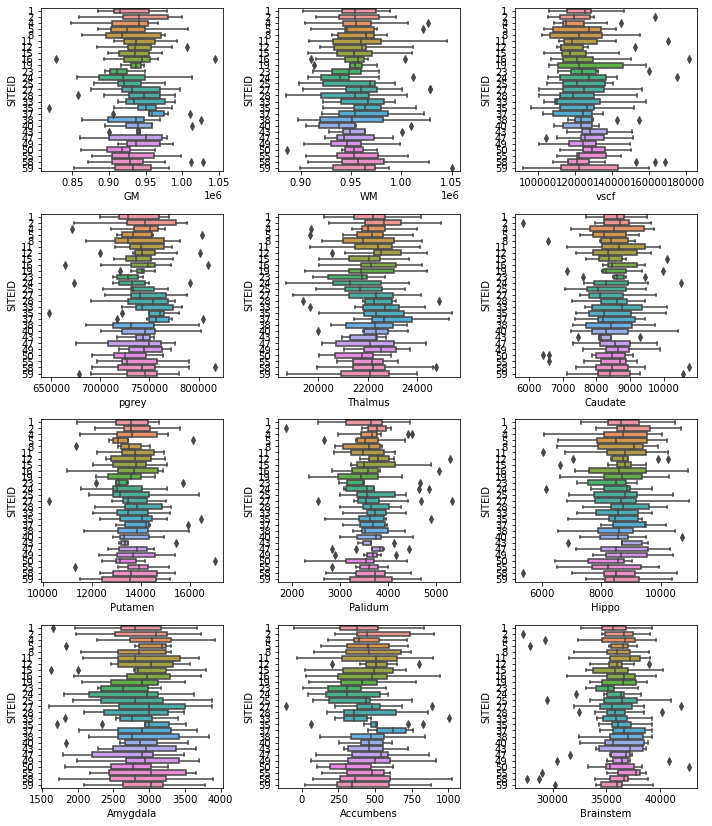

In [5]:
# Explor variability of features by site after harmonization
df_features_harm = pd.DataFrame(data=y_adjusted, columns=features)
df_features_harm['SITEID'] = df_cn_homo['SITEID'].reset_index(drop=True)
plt.figure(figsize=(10,14))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    ax = sns.boxplot(x=feature, y='SITEID', data=df_features_harm, orient='h')
    plt.tight_layout()

Data harmonization does not create perfectly aligned box plots because the dependent variable age has different distributions for each site as seen in preprocesing. Age matching was carried out on the whole cohort and not by site.

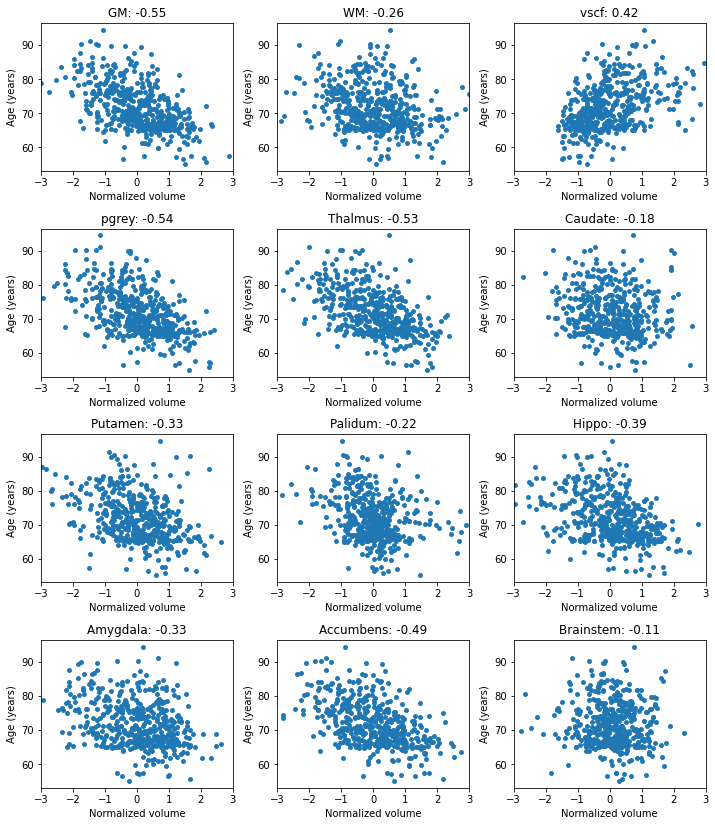

In [6]:
# Exctract features
if COMBAT:
    X = df_features_harm[features].to_numpy()
    Y = df_cn_homo['AGE'].to_numpy()
else:
    X = df_cn[features].to_numpy()
    Y = df_cn['AGE'].to_numpy()

# Generate train and test partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0)

# Data normalization
transformer = StandardScaler().fit(X_train)  # fit() learns mean and std parameters
X_train_norm = transformer.transform(X_train) # transform() normalizes
X_test_norm =  transformer.transform(X_test)
  
# Explore relationship between each individual feature and age.
plt.figure(figsize=(10,14))
for d in range (len(features)):
    plt.subplot(5,3,d+1)
    plt.scatter(X_train_norm[:,d],Y_train,s=15)
    pearson_coeff, _ = pearsonr(X_train_norm[:, d], Y_train)
    plt.xlabel('Normalized volume')
    plt.ylabel('Age (years)')
    plt.xlim([-3.0, 3.0])
    plt.title("{0}: {1:.2f}".format(features[d],pearson_coeff))
plt.tight_layout()
plt.savefig('figures/age_vs_neuroimage_features.svg')

There are many features that are clearly linearly related with our dependent variable.

MAE in test: 4.138052


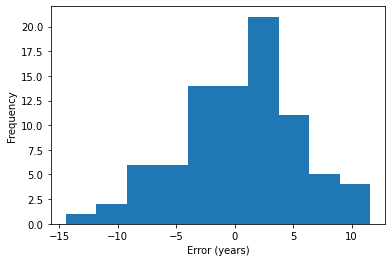

In [7]:
# Train linear regression model
LR_brainage = LinearRegression(fit_intercept='True')
LR_brainage.fit(X_train_norm, Y_train)

# Compute the predictions over test data
f_test = LR_brainage.predict(X_test_norm)
delta_cn = f_test - Y_test
MAE_test = np.mean(np.abs(delta_cn))
print('MAE in test: %f' % MAE_test)
plt.xlabel('Error (years)')
plt.ylabel('Frequency')
plt.hist(delta_cn)
plt.show()

An okay MAE is achieved with a very simple linear regression model. The best models to estimate have an MAE just below 3. Although they cover a much larger age range usually 5 to 90 instead of 65 to 90. Previous works have already described the linear relationship between brain structures and age for age ranges of 65 to 90. Modelling age is more difficult when mixining both young and old patients. We are only interested for AD pathology in older populations.

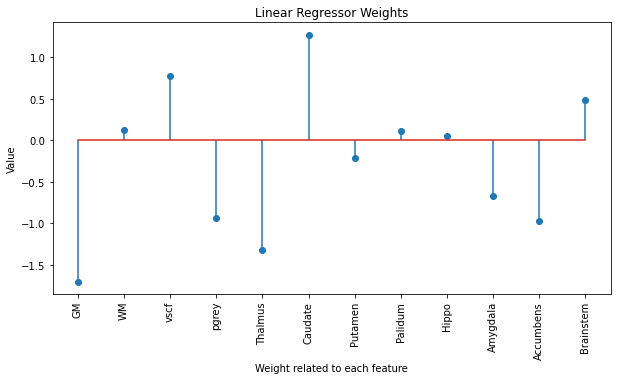

In [8]:
# Linear regressor weights as a measure of importance
LR_weights = LR_brainage.coef_

# Plot weights
plt.figure(figsize=(10,5))
plt.title('Linear Regressor Weights')
plt.stem(features, LR_weights)
plt.xticks(rotation='vertical')
plt.xlabel('Weight related to each feature')
plt.ylabel('Value')
plt.show()

The sign of the weights might not agree with those shown in the correlation analysis because in the correlation analysis we are only taking into account the relationship between the dependendent variable and each variable individiually. Whereas the indepedent variables can be correlated between them and so for example compensate each other since for example pgrey_norm is heavly correlated with GM_norm.

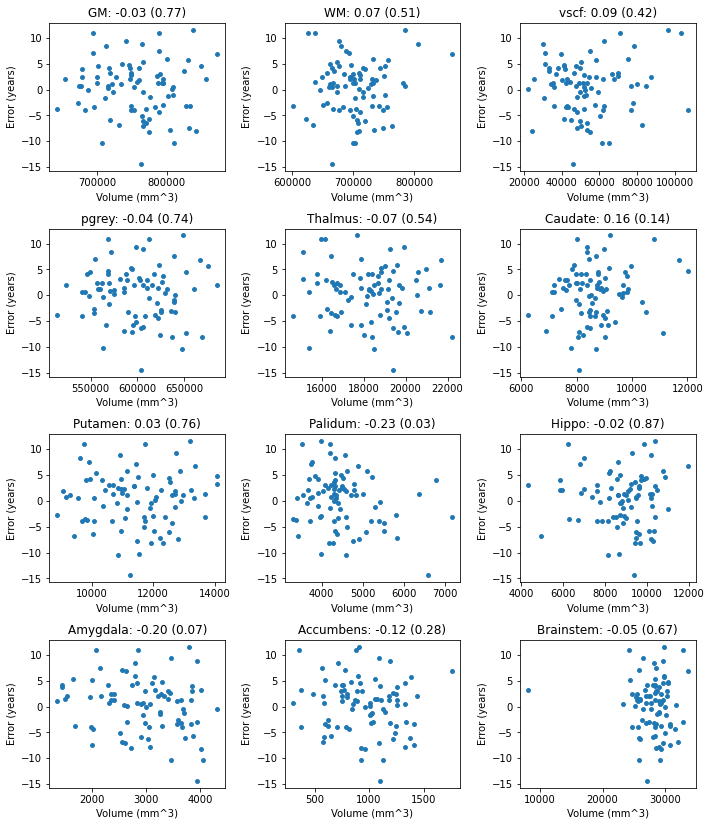

In [9]:
# Explore if there is any correlation between features and delta in controls
plt.figure(figsize=(10,14))
for d in range (len(features)):
    plt.subplot(5,3,d+1)
    plt.scatter(X_test[:,d], delta_cn,s=15)
    plt.xlabel('Volume (mm^3)')
    plt.ylabel('Error (years)')
    pearson_coeff, pval = pearsonr(X_test[:, d], delta_cn)
    plt.title("{0}: {1:.2f} ({2:.2f})".format(features[d],pearson_coeff,pval))
plt.tight_layout()

As expected there is no direct correaltion between brain deltas in controls and the features.

We can test more complex models to see if we obtain better fits.

In [10]:
# Performance evaluation of Ridge Regressor with Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Variables
alpha_values_ridge = np.logspace(-2, 3, num=30)
tuned_parameters_ridge = [{'alpha': alpha_values_ridge}]
nfold = 5

# Create pipeline (Creatue poly features, normalize features, use these to train model)
steps = [('poly', PolynomialFeatures()), ('normalize', StandardScaler()), ('clf', Ridge())]
pipe_Ridge = Pipeline(steps)

# Do not include a bias term when creating features
pipe_Ridge.set_params(poly__include_bias=False)
# Make sure the bias is fit
pipe_Ridge.set_params(clf__fit_intercept=True)

# CV range of values to check
param_grid_Ridge = dict(poly__degree=[1, 2, 3], clf__alpha = alpha_values_ridge)

# Create CV grid search
pipe_grid_search_Ridge = GridSearchCV(pipe_Ridge, param_grid=param_grid_Ridge, cv=nfold, scoring='neg_mean_squared_error')
# No need to feed normalized data as it will be normalized in the pipeline
pipe_grid_search_Ridge.fit(X_train, Y_train)

# Optimum hyperparameter values
PolyRidge_degree_opt = pipe_grid_search_Ridge.best_params_['poly__degree']
print('Optimum value of polynomial degree is %d' % PolyRidge_degree_opt)
PolyRidge_alpha_opt = pipe_grid_search_Ridge.best_params_['clf__alpha']
print('Optimum value of alpha is %.2f' % PolyRidge_alpha_opt)

# Compute the predictions over train and test data
PolyRidge_f_train = pipe_grid_search_Ridge.predict(X_train)
PolyRidge_f_test = pipe_grid_search_Ridge.predict(X_test)

# Calculate MSE for both train and test
PolyRidge_MAE_train = metrics.mean_absolute_error(Y_train, PolyRidge_f_train)
PolyRidge_MAE_test = metrics.mean_absolute_error(Y_test, PolyRidge_f_test)

# Show result
print("The trained Ridge regressor with polynomial features has an MSE for the training data of: %.2f" % PolyRidge_MAE_train)
print("The trained Ridge regressor with polynomial features has an MSE for the test data of: %.2f" % PolyRidge_MAE_test)

Optimum value of polynomial degree is 3
Optimum value of alpha is 672.34
The trained Ridge regressor with polynomial features has an MSE for the training data of: 3.99
The trained Ridge regressor with polynomial features has an MSE for the test data of: 4.11


In [11]:
# Performance evaluation of weighted KNN
from sklearn.neighbors import KNeighborsRegressor

# Define tuned_parameters
rang_K = range(1, 21)
tuned_parameters_kNN  = dict(kNN__n_neighbors = rang_K)

# Create pipeline and ensure neighbours are weighted by the inverse of their distance
pipe_WkNN = Pipeline([('scaler', StandardScaler()), ('kNN', KNeighborsRegressor(weights='distance'))])

# Create a gridSearch over the pipeline
pipe_grid_search_WkNN = GridSearchCV(pipe_WkNN, tuned_parameters_kNN, cv=nfold, scoring='neg_mean_squared_error')

# Train
pipe_grid_search_WkNN.fit(X_train, Y_train)

# Optimum hyperparameter values
Weighted_KNN_neighbors_opt = pipe_grid_search_WkNN.best_params_['kNN__n_neighbors']
print('Optimum value of neighbors is %d' %Weighted_KNN_neighbors_opt)


# Compute the predictions over train and test data
Weighted_KNN_f_train = pipe_grid_search_WkNN.predict(X_train)
Weighted_KNN_f_test = pipe_grid_search_WkNN.predict(X_test)

# Calculate MSE for both train and test
Weighted_KNN_MAE_train = metrics.mean_absolute_error(Y_train, Weighted_KNN_f_train)
Weighted_KNN_MAE_test = metrics.mean_absolute_error(Y_test, Weighted_KNN_f_test)

# Show result
print("The trained kNN has an MSE for the training data of: %.2f" % Weighted_KNN_MAE_train)
print("The trained kNN has an MSE for the test data of: %.2f" % Weighted_KNN_MAE_test)

Optimum value of neighbors is 20
The trained kNN has an MSE for the training data of: 0.00
The trained kNN has an MSE for the test data of: 3.92


In [12]:
# Generate Sklearn Gradient Boosting Classifier
import xgboost as xgb
xgbR= xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=7,
                       subsample=0.1, learning_rate=0.1)
    
# Train
xgbR.fit(X_train_norm, Y_train)

# Compute the predictions over test data
f_test_xgbr = xgbR.predict(X_test_norm)
errors_xgbr = Y_test-f_test_xgbr
MAE_test_xgbr = np.mean(np.abs(errors_xgbr))
print('MAE in test: %f' % MAE_test_xgbr)

/Users/jorgegarciacondado/opt/anaconda3/envs/adni/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


MAE in test: 4.682110


There is no big improvement in any of the more complex models so following occam's razor we use the linear regressor for further analysis.

There is a bias in the model as younger controls tend to be given higher ages than they have and older patients are given lower ages than they have. It can be thought of in terms of our best estimate for a subject which we know nothing is the median so younger patients would be given older ages and older patients lower ages (A.G. de Lange & J. H. Cole 2020).

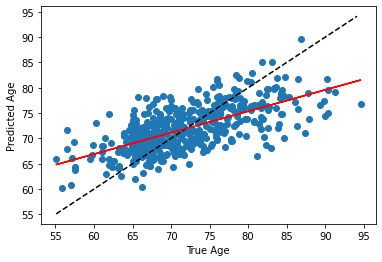

In [13]:
# Explore relationship between age and delta
f_train = LR_brainage.predict(X_train_norm)
LR_age_bias = LinearRegression(fit_intercept='True')
LR_age_bias.fit(Y_train.reshape(-1, 1), f_train)
age_range = np.arange(np.min(Y_train), np.max(Y_train))
plt.plot(age_range, age_range, color='k', linestyle='dashed')
plt.plot(Y_train, LR_age_bias.predict(Y_train.reshape(-1,1)), color='r')
plt.scatter(Y_train, f_train)
plt.ylabel('Predicted Age')
plt.xlabel('True Age')
plt.show()

However, this can be fixed by adjusting the predicted BrainAge taking into account the actual age of the patient to correct for this bias, as shown below:

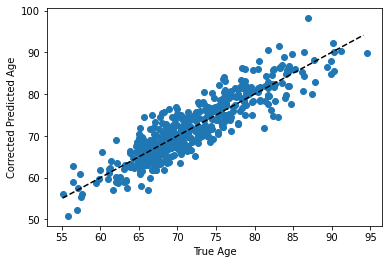

In [14]:
f_train_no_bias = f_train + (Y_train-LR_age_bias.predict(Y_train.reshape(-1, 1)))
plt.scatter(Y_train, f_train_no_bias)
plt.plot(age_range, age_range, color='k', linestyle='dashed')
plt.ylabel('Corrected Predicted Age')
plt.xlabel('True Age')
plt.show()

MAE in test: 2.611578


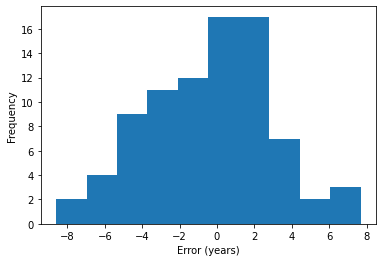

In [15]:
# Compute the predictions over test data with bias correction
f_test = LR_brainage.predict(X_test_norm)
f_test_no_bias = f_test + (Y_test-LR_age_bias.predict(Y_test.reshape(-1, 1)))
delta_cn = f_test_no_bias - Y_test
MAE_test = np.mean(np.abs(delta_cn))
print('MAE in test: %f' % MAE_test)
plt.xlabel('Error (years)')
plt.ylabel('Frequency')
plt.hist(delta_cn)
plt.show()

There is a big improvment by removing the age bias. It is important to remove the age bias for further analysis to see difference between CN, MCI and AD indepdent of age.

### Analysis of brain deltas

An exploration of the difference between the predicted age by the model and the real age of participants, which we call the brain delta. The model is trained on healthy controls so we expect that MCI and AD patients might have significantly different deltas.

In [16]:
# Harmonize all data
if COMBAT:
    df_full = df_full_homo
    Y = df_full[features].to_numpy()
    b = df_full['SITEID'].to_numpy()
    X = df_full['AGE'].to_numpy()[:, np.newaxis]
    C = df_full[['Vscale', 'PTGENDER', 'Phase']].to_numpy()
    y_adjusted = combat.transform(Y=Y, b=b, X=X, C=C)
    X_norm = transformer.transform(y_adjusted)
else:
    Y = df_full[features].to_numpy()
    X_norm = transformer.transform(Y)
age = df_full['AGE'].to_numpy()
df_full['StructBrainAge'] = LR_brainage.predict(X_norm) + (age-LR_age_bias.predict(age.reshape(-1,1)))
df_full['StructBrainDelta'] = df_full['StructBrainAge']-df_full['AGE']

# Save to csv
if not COMBAT:
    fname = 'adni_brainage'
else:
    fname = 'adni_brainage_homogenisation'

if exists('../DATA/%s.csv' % fname):
    df_brainages = pd.read_csv('../DATA/%s.csv' % fname, index_col=0)
    if 'StructBrainAge' in df_brainages:
        df_brainages.drop(['StructBrainAge', 'StructBrainDelta'], axis=1, inplace=True)
else:
    df_brainages = pd.DataFrame(df_full[['RID', 'TYPECONVERSOR']].copy(), columns=['RID', 'TYPECONVERSOR'])

df_brainages = df_brainages.merge(df_full[['RID', 'StructBrainAge', 'StructBrainDelta']], on=['RID'])
df_brainages.to_csv('../DATA/%s.csv' % fname)

In [17]:
# Cohen's d size: 0.01 Very small, 0.2 Small, 0.5 Medium, 0.8 Large, 1.2 Very large, 2.0 Huge
def cohen_d(x,y):
        return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

Brain delta mean for
CN: -0.316764 (3.283887)
MCI: 1.923765 (3.973030)
AD: 4.975576 (4.497311)
Brain delta median for
CN: 0.037303
MCI: 1.885098
AD: 5.048206
p-value
CN vs MCI: 9.025543e-07
CN vs AD: 4.735570e-19
MCI vs AD: 2.607938e-17
Cohens d
CN vs MCI: -0.612939
CN vs AD: -1.339139
MCI vs AD: 0.717990


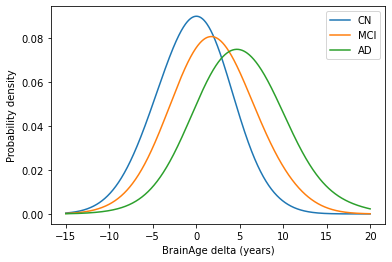

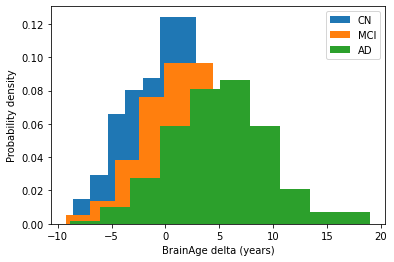

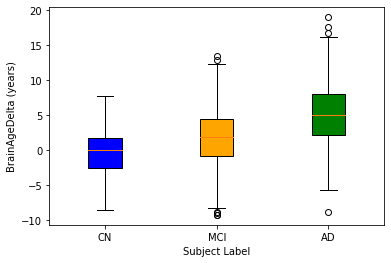

In [18]:
# Explore difference between CN, MCI and AD deltas
df_mci = df_full[df_full['DIAGNOSIS']==2.0]
df_ad = df_full[df_full['DIAGNOSIS']==3.0]

# Make estimations
delta_mci = df_mci['StructBrainDelta'].to_numpy()
delta_ad = df_ad['StructBrainDelta'].to_numpy()

# Obtain mean and medians for each
print('Brain delta mean for')
print('CN: %f (%f)' % (np.mean(delta_cn), np.std(delta_cn)))
print('MCI: %f (%f)' % (np.mean(delta_mci), np.std(delta_mci)))
print('AD: %f (%f)' % (np.mean(delta_ad), np.std(delta_ad)))
print('Brain delta median for')
print('CN: %f' % np.median(delta_cn))
print('MCI: %f' % np.median(delta_mci))
print('AD: %f' % np.median(delta_ad))

# Calculate p-value
print('p-value')
hstat_cnvsmci, pval_cnvsmci = kruskal(delta_cn, delta_mci)
hstat_cnvsad, pval_cnvsad = kruskal(delta_cn, delta_ad)
hstat_mcivsad, pval_mcivsad = kruskal(delta_ad, delta_mci)
print('CN vs MCI: %e' % Decimal(pval_cnvsmci))
print('CN vs AD: %e' % Decimal(pval_cnvsad))
print('MCI vs AD: %e' % Decimal(pval_mcivsad))

# Calculate cohen's d size
print('Cohens d')
cohend_cnvsmci = cohen_d(delta_cn, delta_mci)
cohend_cnvsad = cohen_d(delta_cn, delta_ad)
cohend_mcivsad = cohen_d(delta_ad, delta_mci)
print('CN vs MCI: %f' % cohend_cnvsmci)
print('CN vs AD: %f' % cohend_cnvsad)
print('MCI vs AD: %f' % cohend_mcivsad)

# Plot kernel density estimates for samples
from sklearn.neighbors import KernelDensity
X_plot = np.linspace(-15, 20, 1000)[:, np.newaxis]
kde_cn = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_cn[:, np.newaxis])
log_dens_cn = kde_cn.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_cn), label='CN')
kde_mci = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
kde_ad = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_ad[:, np.newaxis])
log_dens_ad = kde_ad.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='AD')
plt.xlabel('BrainAge delta (years)')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot histogram
plt.hist(delta_cn, label='CN', density=True)
plt.hist(delta_mci, label='MCI', density=True)
plt.hist(delta_ad, label='AD', density=True)
plt.xlabel('BrainAge delta (years)')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot boxplots
fig = plt.figure()
ax = fig.add_subplot(111)
bp = ax.boxplot([delta_cn, delta_mci, delta_ad], patch_artist = True,
                labels=['CN', 'MCI', 'AD'])
colors = ['b', 'orange',
          'g']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('Subject Label')
plt.ylabel('BrainAgeDelta (years)')
plt.show()

There is clearly a difference in brain age deltas between CN, MCI and AD as already previously shown in other publications.

### Analysis of conversors

Analyse the value of brain delta as a biomarker for conversors. That is either CN that progress to MCI or MCI that progress to AD.

p-value of age distributions
CN vs CN2MCI: 0.003638
Brain delta mean for
CN: -0.316764
CN2MCI: 1.744938
Brain delta median for
CN: 0.037303
CN2MCI: 1.034948
p-value
CN vs CN2MCI: 0.004080
Cohens d
CN vs CN2MCI: -0.552335


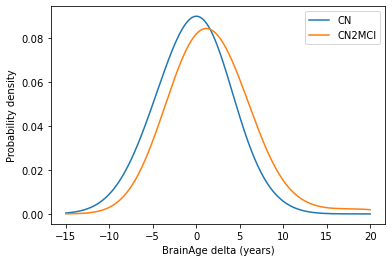

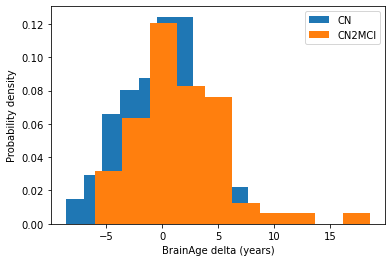

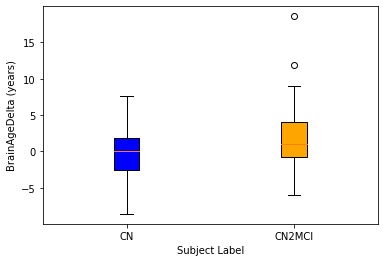

In [19]:
# Explore differences between CN and CN2MCI conversors
df_cn2mci = df_full[df_full['TYPECONVERSOR']==4.0]
delta_cn2mci = df_cn2mci['StructBrainDelta'].to_numpy()

# Check p-values between groups for age not different
mci_age_noconv = df_cn['AGE'].to_numpy()
mci_age_conv = df_cn2mci['AGE'].to_numpy()
print('p-value of age distributions')
hstat_noconvvsconv_age, pval_noconvvsconv_age = kruskal(mci_age_noconv, mci_age_conv)
print('CN vs CN2MCI: %f' % pval_noconvvsconv_age)

# Obtain mean and medians for each
print('Brain delta mean for')
print('CN: %f' % np.mean(delta_cn))
print('CN2MCI: %f' % np.mean(delta_cn2mci))
print('Brain delta median for')
print('CN: %f' % np.median(delta_cn))
print('CN2MCI: %f' % np.median(delta_cn2mci))

# Calculate p-value
print('p-value')
hstat_cn2mci, pval_cn2mci = kruskal(delta_cn, delta_cn2mci)
print('CN vs CN2MCI: %f' % pval_cn2mci)

# Calculate cohen's d size
print('Cohens d')
cohend_cn2mci = cohen_d(delta_cn, delta_cn2mci)
print('CN vs CN2MCI: %f' % cohend_cn2mci)

# Plot kernel densities
kde_cn = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_cn[:, np.newaxis])
log_dens_cn = kde_cn.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_cn), label='CN')
kde_mci = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_cn2mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='CN2MCI')
plt.xlabel('BrainAge delta (years)')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot histogram
plt.hist(delta_cn, label='CN', density=True)
plt.hist(delta_cn2mci, label='CN2MCI', density=True)
plt.xlabel('BrainAge delta (years)')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot boxplots
fig = plt.figure()
ax = fig.add_subplot(111)
bp = ax.boxplot([delta_cn, delta_cn2mci], patch_artist = True,
                labels=['CN', 'CN2MCI'])
colors = ['b', 'orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('Subject Label')
plt.ylabel('BrainAgeDelta (years)')
plt.show()

There is a slight difference in brain age deltas between CN that do not convert to MCI and those that do. This difference seems to be due to a few outliers from graph. This might have had big cognitive decline causing big brain age deltas.

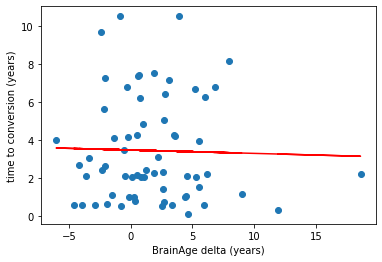

Model metrics:
R^2: 0.000700
Pearson coeff (p-value): -0.026463 (0.835569)


In [20]:
# Explore relationship between conversion time and brain delta for CN2MCI

# Plot linear regression
times = df_cn2mci['TIME2CONVERSION'].to_numpy()
LR_cn2mci = LinearRegression()
LR_cn2mci.fit(delta_cn2mci.reshape(-1, 1), times.reshape(-1, 1))
predicted_times = LR_cn2mci.predict(delta_cn2mci.reshape(-1, 1))
 
# predicted values
plt.plot(delta_cn2mci, predicted_times, color='r')
plt.scatter(delta_cn2mci, times)
plt.xlabel('BrainAge delta (years)')
plt.ylabel('time to conversion (years)')
plt.show()

print('Model metrics:')
print('R^2: %f' % metrics.r2_score(times, predicted_times))
pearson_coeff, pval = pearsonr(times, delta_cn2mci)
print('Pearson coeff (p-value): %f (%f)' % (pearson_coeff, pval))

A good biomarker should show that with increased value the conversion time should be smaller. There is no statistically significant relationship between brain deltas and time to conversion from CN to MCI. Showing that BrainAge is not a reliable biomarker for conversion from CN to MCI.

p-value of age distributions
MCI vs MCI2AD: 0.089544
Brain delta mean for
MCI: 1.606599
MCI2AD: 3.577069
Brain delta median for
MCI: 1.689760
MCI2AD: 3.413574
p-value
MCI vs MCI2AD: 0.000000
Cohens d
MCI vs MCI2AD: -0.509131


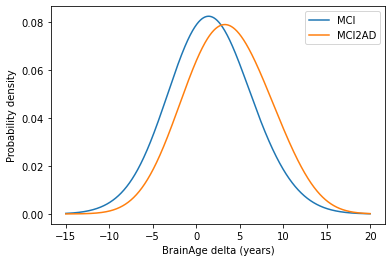

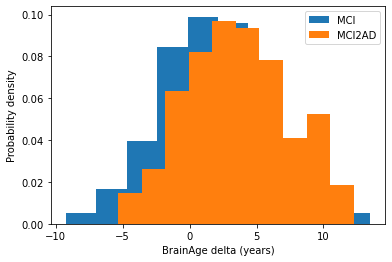

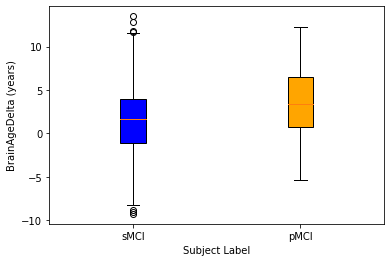

In [21]:
# Explore differences between MCI and CN2MCI conversors
df_mci = df_full[df_full['TYPECONVERSOR']==2.0]
df_mci2ad = df_full[df_full['TYPECONVERSOR']==5.0]
delta_mci2ad = df_mci2ad['StructBrainDelta'].to_numpy()
delta_mci = df_mci['StructBrainDelta'].to_numpy()

# Check p-values between groups for age not different
mci_age_noconv = df_mci['AGE'].to_numpy()
mci_age_conv = df_mci2ad['AGE'].to_numpy()
print('p-value of age distributions')
hstat_noconvvsconv_age, pval_noconvvsconv_age = kruskal(mci_age_noconv, mci_age_conv)
print('MCI vs MCI2AD: %f' % pval_noconvvsconv_age)

# Obtain mean and medians for each
print('Brain delta mean for')
print('MCI: %f' % np.mean(delta_mci))
print('MCI2AD: %f' % np.mean(delta_mci2ad))
print('Brain delta median for')
print('MCI: %f' % np.median(delta_mci))
print('MCI2AD: %f' % np.median(delta_mci2ad))

# Calculate t-test
print('p-value')
hstat_mci2ad, pval_mci2ad = kruskal(delta_mci, delta_mci2ad)
print('MCI vs MCI2AD: %f' % pval_mci2ad)

# Calculate cohen's d size
print('Cohens d')
cohend_mci2ad = cohen_d(delta_mci, delta_mci2ad)
print('MCI vs MCI2AD: %f' % cohend_mci2ad)

# Plot kernel density estimates
kde_mci = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
kde_ad = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_mci2ad[:, np.newaxis])
log_dens_ad = kde_ad.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='MCI2AD')
plt.xlabel('BrainAge delta (years)')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot histograms
plt.hist(delta_mci, label='MCI', density=True)
plt.hist(delta_mci2ad, label='MCI2AD', density=True)
plt.xlabel('BrainAge delta (years)')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot boxplots
fig = plt.figure()
ax = fig.add_subplot(111)
bp = ax.boxplot([delta_mci, delta_mci2ad], patch_artist = True,
                labels=['sMCI', 'pMCI'])
colors = ['b', 'orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('Subject Label')
plt.ylabel('BrainAgeDelta (years)')
plt.show()

There is statistically significant difference between MCI and MCI2AD conversros in terms of their brain age deltas.

In [22]:
total_mci = len(df_full[df_full['DIAGNOSIS']==2.0])
mci_noconv = len(df_full[df_full['TYPECONVERSOR']==2.0])
mci_conv = len(df_full[df_full['TYPECONVERSOR']==5.0])
mci_reverse = len(df_full[df_full['TYPECONVERSOR']==7.0])
print('Percentage of patient types:')
print('MCI -> MCI: %f' % (mci_noconv/total_mci))
print('MCI -> AD: %f' % (mci_conv/total_mci))
print('MCI -> CN: %f' % (mci_reverse/total_mci))

Percentage of patient types:
MCI -> MCI: 0.664567
MCI -> AD: 0.239370
MCI -> CN: 0.096063


The percentage of patients converting to AD is similar to those previously reported in other studies which range from 15% to 25%.

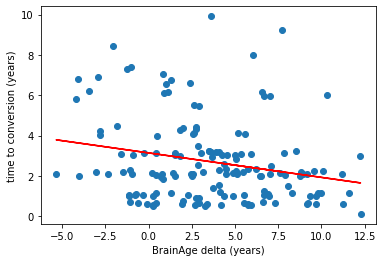

Model metrics:
R^2: 0.053054
Pearson coeff (p-value): -0.230335 (0.004306)


In [23]:
# Explore relationship between conversion time and brain delta for MCI2AD

# Plot linear regression
times = df_mci2ad['TIME2CONVERSION'].to_numpy()
LR_mci2ad = LinearRegression()
LR_mci2ad.fit(delta_mci2ad.reshape(-1, 1), times.reshape(-1, 1))
predicted_times = LR_mci2ad.predict(delta_mci2ad.reshape(-1, 1))
 
# predicted values
plt.plot(delta_mci2ad, predicted_times, color='r')
plt.scatter(delta_mci2ad, times)
plt.xlabel('BrainAge delta (years)')
plt.ylabel('time to conversion (years)')
plt.show()

print('Model metrics:')
print('R^2: %f' % metrics.r2_score(times, predicted_times))
pearson_coeff, pval = pearsonr(times, delta_mci2ad)
print('Pearson coeff (p-value): %f (%f)' % (pearson_coeff, pval))

There seems to be a good correlation between brain age deltas and the time taken to convert from MCI to AD. This comes to show that brainAge deltas are a good biomarker candidate for conversion from MCI to AD.

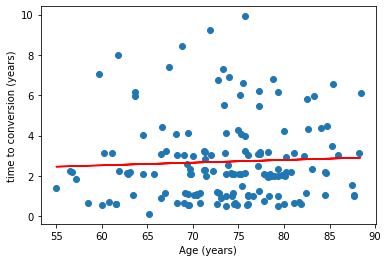

Model metrics:
R^2: 0.002304
Pearson coeff (p-value): 0.047996 (0.557080)


In [24]:
# Explore relationship between conversion time and age
ages_mci2ad = df_mci2ad['AGE'].to_numpy()
LR_mci2ad = LinearRegression()
LR_mci2ad.fit(ages_mci2ad.reshape(-1, 1), times.reshape(-1, 1))
predicted_times = LR_mci2ad.predict(ages_mci2ad.reshape(-1, 1))
 
# predicted values
plt.plot(ages_mci2ad, predicted_times, color='r')
plt.scatter(ages_mci2ad, times)
plt.xlabel('Age (years)')
plt.ylabel('time to conversion (years)')
plt.show()

print('Model metrics:')
print('R^2: %f' % metrics.r2_score(times, predicted_times))
pearson_coeff, pval = pearsonr(times, ages_mci2ad)
print('Pearson coeff (p-value): %f (%f)' % (pearson_coeff, pval))

The time to conversion for MCI2AD patients does not seem to be correlated with age, i.e. older patients don't convert faster than younger ones.

In [25]:
# Explore relationship between features and conversors and non-conversors
features_mci = df_mci[features].to_numpy()
features_mci2ad = df_mci2ad[features].to_numpy()
bonferroni_corrected_val = 0.05/len(features)
print('p-value MCI vs MCI2AD (<%f)'%bonferroni_corrected_val)
significant_features = []
for d in range(len(features)):
    hstat_mci2ad, pval_mci2ad = kruskal(features_mci[:, d], features_mci2ad[:, d])
    print('%s: %f' % (features[d], pval_mci2ad))
    if pval_mci2ad < bonferroni_corrected_val:
        significant_features.append(d)

p-value MCI vs MCI2AD (<0.004167)
GM: 0.000005
WM: 0.063932
vscf: 0.042701
pgrey: 0.000000
Thalmus: 0.000439
Caudate: 0.479738
Putamen: 0.008075
Palidum: 0.809339
Hippo: 0.000251
Amygdala: 0.244812
Accumbens: 0.000888
Brainstem: 0.517002


There are several features that are on there own good indicators of wether a patient is a conversor or not. Several papers already showed Hippocampus as a biomarker for conversion. The significant features also have big weight values in our BrainAge Linear Regression model.

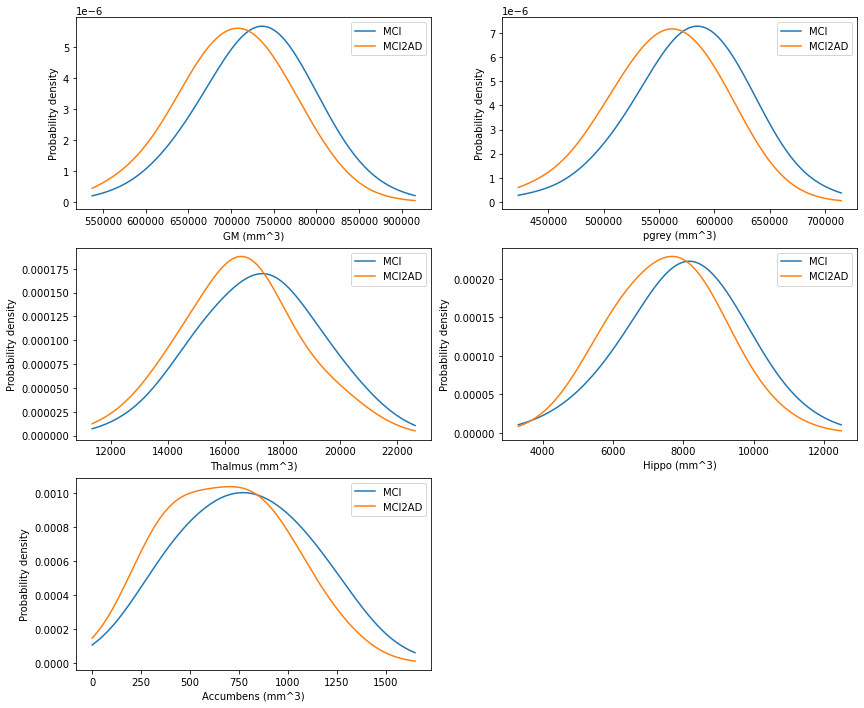

In [26]:
plt.figure(figsize=(14,12))
for i, f in enumerate(significant_features):
    plt.subplot(3,2,i+1)
    min_val, max_val = np.min(features_mci[:, f]), np.max(features_mci[:, f])
    range_vals = max_val - min_val
    X_plot = np.linspace(min_val, max_val, 1000)[:, np.newaxis]
    # Plot kernel density estimates
    kde_mci = KernelDensity(kernel="gaussian", bandwidth=range_vals/10).fit(features_mci[:, f].reshape(-1, 1))
    log_dens_mci = kde_mci.score_samples(X_plot)
    plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
    kde_ad = KernelDensity(kernel="gaussian", bandwidth=range_vals/10).fit(features_mci2ad[:, f].reshape(-1, 1))
    log_dens_ad = kde_ad.score_samples(X_plot)
    plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='MCI2AD')
    plt.xlabel('%s (mm^3)' % features[f])
    plt.ylabel('Probability density')
    plt.legend()
plt.show()

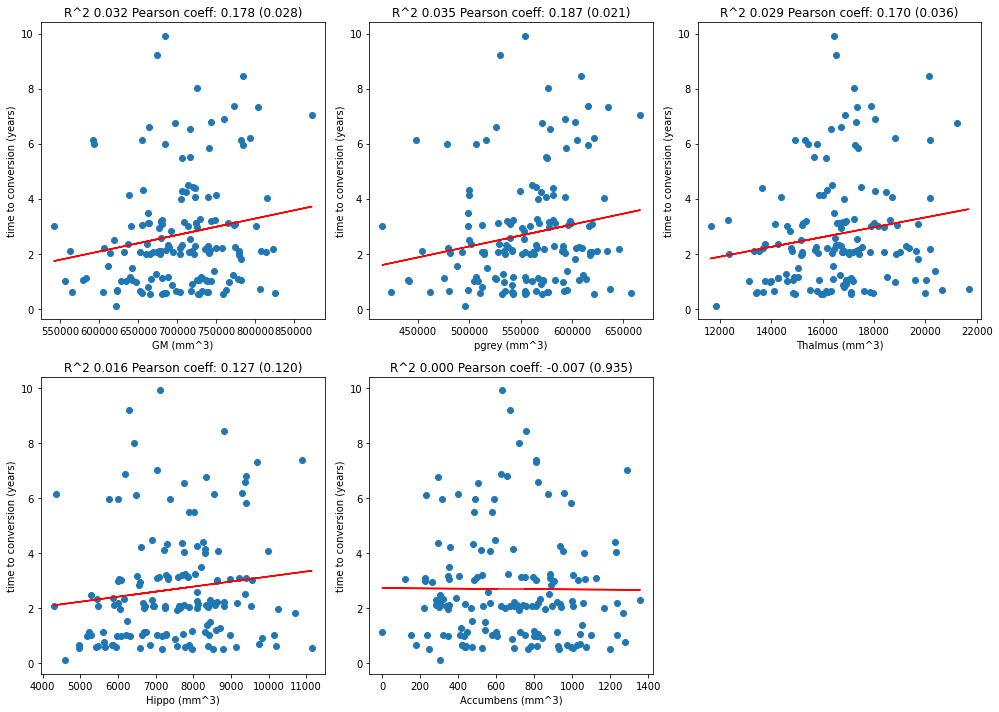

In [27]:
# Explore relationship between significant figures and time to conversion
plt.figure(figsize=(14,10))
for i, f in enumerate(significant_features):
    plt.subplot(2, 3, i+1)
    feature = features_mci2ad[:, f]
    LR_mci2ad = LinearRegression()
    LR_mci2ad.fit(feature.reshape(-1, 1), times.reshape(-1, 1))
    predicted_times = LR_mci2ad.predict(feature.reshape(-1, 1))
 
    # predicted values
    plt.plot(feature, predicted_times, color='r')
    plt.scatter(feature, times)
    plt.xlabel('%s (mm^3)' % features[f])
    plt.ylabel('time to conversion (years)')
    
    # add metrics
    r2 = metrics.r2_score(times, predicted_times)
    pearson_coeff, pval = pearsonr(times, feature)
    plt.title('R^2 %.3f Pearson coeff: %.3f (%.3f)' % (r2, pearson_coeff, pval))    

plt.tight_layout()
plt.show()

GM, pgrey and the Thalmus seem to have a significant relationship with time to conversion were as the Hippo and Accumbens is not so clear. However, the brainAge delta has a much stronger relationship.

### Homogenisation

If we run the same analysis but homogenising data by taking into account also the site, gender and phase of each subject using COMBAT the results are very similar but there are some differences.

Differences:
- There is a better MAE before age bias correction.
- The difference in means between groups is more pronounced.
- There is a stronger correlation between braiAge delta and time to conversion.
- Only pgrey is a significant feature after homogenisation.